In [1]:
import pandas as pd 
import numpy as np
import os
os.chdir("/content/drive/MyDrive/data_format1")
userinfo=pd.read_csv('/content/drive/MyDrive/data_format1/user_info_format1.csv')
userlog=pd.read_csv('/content/drive/MyDrive/data_format1/user_log_format1.csv')
train=pd.read_csv('/content/drive/MyDrive/data_format1/train_format1.csv')

In [ ]:
userlog.head

<bound method NDFrame.head of           user_id  item_id  cat_id  ...  brand_id  time_stamp  action_type
0          328862   323294     833  ...    2661.0         829            0
1          328862   844400    1271  ...    2661.0         829            0
2          328862   575153    1271  ...    2661.0         829            0
3          328862   996875    1271  ...    2661.0         829            0
4          328862  1086186    1271  ...    1049.0         829            0
...           ...      ...     ...  ...       ...         ...          ...
54925325   208016   107662     898  ...    7995.0        1110            0
54925326   208016  1058313     898  ...    7995.0        1110            0
54925327   208016   449814     898  ...    7995.0        1110            0
54925328   208016   634856     898  ...    7995.0        1110            0
54925329   208016   272094     898  ...    7995.0        1111            0

[54925330 rows x 7 columns]>

In [ ]:
#Check Missing Value
def missing_cal(df):
    missing_series = df.isnull().sum()/df.shape[0]
    missing_df = pd.DataFrame(missing_series).rename(columns={'index':'col',0:'missing_pct'}).sort_values('missing_pct',ascending=False).reset_index()
    return missing_df
missing_cal(userlog)


userinfo['age_range']= userinfo['age_range'].replace({0:np.nan})
userinfo['gender']= userinfo['gender'].replace({2:np.nan})
missing_cal(userinfo)

,index,missing_pct
0,age_range,0.224276
1,gender,0.039753
2,user_id,0.000000


In [2]:
#Missing Value Repairment
userlog['brand_id'].fillna(userlog['brand_id'].mode()[0],inplace=True)

userinfo['gender'].fillna(userinfo['gender'].mode()[0],inplace=True)

userinfo['age_range'].fillna(userinfo['age_range'].median(),inplace=True)

In [3]:
#Duplicates Removal
userinfo=userinfo.drop_duplicates()

In [5]:
# Format the date
userlog['month']=userlog['time_stamp']//100
userlog['day']=userlog['time_stamp']%100

In [6]:
# Format the data fields
userinfo['user_id'] = userinfo['user_id'].astype('int32')
userinfo['age_range'] = userinfo['age_range'].astype('int8')
userinfo['gender'] = userinfo['gender'].astype('int8')

userlog['user_id'] = userlog['user_id'].astype('int32')
userlog['item_id'] = userlog['item_id'].astype('int32')
userlog['cat_id'] = userlog['cat_id'].astype('int32')
userlog.rename(columns={'seller_id':'merchant_id'}, inplace=True)
userlog['merchant_id'] = userlog['merchant_id'].astype('int32')
userlog['brand_id'] = userlog['brand_id'].astype('int32')
# userlog['time_stamp'] = pd.to_datetime(userlog['time_stamp'], format='%H%M')
userlog['action_type'] = userlog['action_type'].astype('int8')

train['user_id'] = train['user_id'].astype('int32')
train['merchant_id'] = train['merchant_id'].astype('int32')
train['label'] = train['label'].astype('int8')

In [7]:
# Copy the data 
data = userlog.copy()
data1 = userinfo.copy()
data2 = train.copy()
del userlog, userinfo, train



All sample train
CPU times: user 696 ms, sys: 19.5 ms, total: 715 ms
Wall time: 718 ms


User Feature

In [ ]:
#User's Gender and AGe
dummy_df = pd.get_dummies(data1.gender, prefix='gender' )
# data1= pd.concat([data1,dummy_df],axis=1).drop('gender',axis=1)
dummy_df = pd.get_dummies(data1.age_range, prefix='age' )
# data1= pd.concat([data1,dummy_df],axis=1).drop('age_range',axis=1)
data2=pd.merge(data2,data1,on=['user_id'])

In [ ]:
data1.head()

,user_id,gender_0.0,gender_1.0,gender_2.0,age_0.0,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,age_8.0
0,376517,0,1,0,0,0,0,0,0,0,1,0,0
1,234512,1,0,0,0,0,0,0,0,1,0,0,0
2,344532,1,0,0,0,0,0,0,0,1,0,0,0
3,186135,1,0,0,0,0,0,0,0,1,0,0,0
4,30230,1,0,0,0,0,0,0,0,1,0,0,0


In [8]:
# Times of use (total)
df=data.groupby(['user_id']).size().reset_index().rename(columns={0:'user_tcnt'})
data2 =pd.merge(data2,df,on=['user_id'])


In [9]:
#  Times of use (monthly)
df=data.groupby(['user_id','month']).size().reset_index().rename(columns={0:'cnt'})
df=pd.get_dummies(df, columns=['month'],prefix='user_mcnt')
for i in range(5,12):
    df['user_mcnt_'+str(i)]=df['cnt']*df['user_mcnt_'+str(i)]
df=df.groupby(['user_id']).sum().drop(['cnt'],axis=1).reset_index()
data2=pd.merge(data2,df,on=['user_id'])

In [10]:
# Times of click/add to favorites /add to shopping cart
for i in set(data['action_type']):
    df=data[data['action_type']==i].groupby(['user_id']).size().reset_index().rename(columns={0:'user_tcnt'+str(i)})
    data2 =pd.merge(data2,df,how='left',on=['user_id'])   
 

In [11]:
# User_Repeat_Ratio
df=data[data['action_type']==2]
df1=df.groupby(['user_id']).agg({'merchant_id':lambda x: len(set(x))}).reset_index().rename(columns={'merchant_id':'user_mer_tcnt'}) #计算购买过的商户数
df2=df.groupby(['user_id','merchant_id']).size().reset_index().rename(columns={0:'cnt'}) 
df2=df2[df2['cnt']>=2].groupby(['user_id']).size().reset_index().rename(columns={0:'repeat_user_cnt'})   #计算重复购买商户数
df=pd.merge(df1,df2,how='left',on='user_id')
df['user_repeat_ratio']=df['repeat_user_cnt']/(df['user_mer_tcnt']+10) #计算回购率
data2 = pd.merge(data2,df[['user_id','user_repeat_ratio']], on=['user_id'], how='left')

Merchant Feature

In [12]:
#Times of Appearing (total)
df=data.groupby(['merchant_id']).size().reset_index().rename(columns={0:'mer_tcnt'})
data2 =pd.merge(data2,df,on=['merchant_id'])


In [13]:
#Times of Appearing (monthly)
df=data.groupby(['merchant_id','month']).size().reset_index().rename(columns={0:'cnt'})
df=pd.get_dummies(df, columns=['month'],prefix='mer_mcnt')
for i in range(5,12):
    df['mer_mcnt_'+str(i)]=df['cnt']*df['mer_mcnt_'+str(i)]
df=df.groupby(['merchant_id']).sum().drop(['cnt'],axis=1).reset_index()
data2=pd.merge(data2,df,on=['merchant_id'])

In [14]:
#Times of being clicked/added to favoriites/added to shooping cart
for i in set(data['action_type']):
    df=data[data['action_type']==i].groupby(['merchant_id']).size().reset_index().rename(columns={0:'mer_tcnt'+str(i)})
    data2 =pd.merge(data2,df,how='left',on=['merchant_id'])   

In [15]:
# Number of user_id, cat_id, brand_id and item_id
list=['user_id','cat_id','brand_id','item_id']
for i in list: 
    df= data.drop_duplicates(['merchant_id',i])
    df= df.groupby(['merchant_id']).size().reset_index().rename(columns={0:'mer_tcnt'+'_'+i[:-3]})
    data2 =pd.merge(data2,df,how='left',on=['merchant_id'])   

In [16]:
#Mer_Repeat_Ratio
df=data[data['action_type']==2]
df1=df.groupby(['merchant_id']).agg({'user_id':lambda x: len(set(x))}).reset_index().rename(columns={'user_id':'user_mer_tcnt'}) #计算购买过的商户数
df2=df.groupby(['merchant_id','user_id']).size().reset_index().rename(columns={0:'cnt'}) 
df2=df2[df2['cnt']>=2].groupby(['merchant_id']).size().reset_index().rename(columns={0:'repeat_user_cnt'})   #计算重复购买商户数
df=pd.merge(df1,df2,how='left',on='merchant_id')
df['mer_repeat_ratio']=df['repeat_user_cnt']/(df['user_mer_tcnt']+10) #计算回购率
data2 = pd.merge(data2,df[['merchant_id','mer_repeat_ratio']], on=['merchant_id'], how='left')

Merchant + User

In [17]:
#Times of use on particualr merchant (total)
df=data.groupby(['user_id','merchant_id']).size().reset_index().rename(columns={0:'user_mer_tcnt'})
data2 =pd.merge(data2,df,on=['user_id','merchant_id'])

In [18]:
#Times of use on particualr merchant (monthly)
df=data.groupby(['user_id','merchant_id','month']).size().reset_index().rename(columns={0:'cnt'})
df=pd.get_dummies(df, columns=['month'],prefix='user_mer_mcnt')
for i in range(5,12):
    df['user_mer_mcnt_'+str(i)]=df['cnt']*df['user_mer_mcnt_'+str(i)]


In [19]:
# df=df.groupby(['user_id','merchant_id']).sum().drop(['cnt'],axis=1).reset_index()
data2=pd.merge(data2,df,on=['user_id','merchant_id'])

In [20]:
# Tims of click/add to favorties/add to shooping cart on particular merchant
for i in set(data['action_type']):
    df=data[data['action_type']==i].groupby(['user_id','merchant_id']).size().reset_index().rename(columns={0:'user_mer_tcnt'+str(i)})
    data2 =pd.merge(data2,df,how='left',on=['user_id','merchant_id'])   

In [21]:
#Number of buyer's past cat_id, brand_id and item_id on particular merchant
list=['cat_id','brand_id','item_id']
for i in list:
    prefix = 'user_mer_'+i[:-3]+'_'
    df = data.groupby(['user_id', 'merchant_id', i]).size().reset_index().rename(columns={0:'cnt'})
    df = df.groupby(['user_id', 'merchant_id']).agg({'cnt':[np.size, np.mean, np.max, np.min]}).reset_index()
    df.columns = ['user_id', 'merchant_id', prefix + 'size', prefix + 'mean', prefix + 'max', prefix + 'min']
    data2 = pd.merge(data2,df, on=['user_id', 'merchant_id'], how='left')


In [22]:
# Times of buyer's using on particular merchant (months)
df=data.groupby(['user_id','merchant_id']).agg({'month':lambda x: len(set(x))}).reset_index().rename(columns={'month':'user_mer_mon_tcnt'}) 
data2 =pd.merge(data2,df,how='left',on=['user_id','merchant_id']) 


In [23]:
# Times of buyer's using on particular merchant (days)
df=data.groupby(['user_id','merchant_id']).agg({'time_stamp':lambda x: len(set(x))}).reset_index().rename(columns={'time_stamp':'user_mer_day_tcnt'}) 
data2 =pd.merge(data2,df,how='left',on=['user_id','merchant_id']) 


In [ ]:
# Ratio of buyers' click/add to favorites/add to shooping cart on particular merchant
data2['user_mu_ratio']=data2['user_mer_tcnt']/(data2['mer_tcnt']+10)
data2['user_mu0_ratio']=data2['user_mer_tcnt0']/(data2['mer_tcnt0']+10)
train['user_mu1_ratio']=data2['user_mer_tcnt1']/(data2['mer_tcnt1']+10)
train['user_mu2_ratio']=data2['user_mer_tcnt2']/(data2['mer_tcnt2']+10)
data2['user_mu3_ratio']=data2['user_mer_tcnt3']/(data2['mer_tcnt3']+10)

In [ ]:
train.to_csv('train.csv')

In [ ]:
train.head()

,user_id,merchant_id,label,age_range,gender,user_tcnt,user_mcnt_5_x,user_mcnt_6_x,user_mcnt_7_x,user_mcnt_8_x,user_mcnt_9_x,user_mcnt_10_x,user_mcnt_11_x,user_tcnt0,user_tcnt1,user_tcnt2,user_tcnt3,user_mcnt_5_y,user_mcnt_6_y,user_mcnt_7_y,user_mcnt_8_y,user_mcnt_9_y,user_mcnt_10_y,user_mcnt_11_y,user_repeat_ratio,user_tcnt_ratio3,user_mu1_ratio,user_mu2_ratio
0,34176,3906,0,6,0,451,48,41,31,44,19,146,122,410.0,NaN,34,7.0,48,41,31,44,19,146,122,0.1250,1.274457e-07,NaN,0.002381
1,34176,121,0,6,0,451,48,41,31,44,19,146,122,410.0,NaN,34,7.0,48,41,31,44,19,146,122,0.1250,1.274457e-07,NaN,0.002381
2,34176,4356,1,6,0,451,48,41,31,44,19,146,122,410.0,NaN,34,7.0,48,41,31,44,19,146,122,0.1250,1.274457e-07,NaN,0.002381
3,34176,2217,0,6,0,451,48,41,31,44,19,146,122,410.0,NaN,34,7.0,48,41,31,44,19,146,122,0.1250,1.274457e-07,NaN,0.002381
4,230784,4818,0,0,0,54,0,28,5,0,4,2,15,47.0,NaN,7,NaN,0,28,5,0,4,2,15,0.0625,NaN,NaN,0.002381


In [24]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

x = data2.loc[:,data2.columns != 'label']
y = data2.loc[:,data2.columns == 'label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

del x_train['user_id'],x_train['merchant_id'],x_test['user_id'],x_test['merchant_id']
duplicate_columns = x_test.columns[x_test.columns.duplicated()]

In [25]:
x_test = x_test.loc[:,~x_test.columns.duplicated()]

In [26]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [27]:
from sklearn.metrics import roc_auc_score,roc_curve,auc

param = {'n_estimators': 500,
         'max_depth': 4, 
         'min_child_weight': 4,
         'gamma':0.3,
         'subsample': 0.8,
         'colsample_bytree': 0.8,  
         'eta': 0.125,
         'silent': 1, 
         'objective': 'binary:logistic',
         'eval_metric':'auc',
         'nthread':17
        }

import xgboost as xgb
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evallist = [(dtrain, 'train'),(dtest,'test')]
bst = xgb.train(param, dtrain, 500,evallist, early_stopping_rounds=10)



x_test_DMatrix = xgb.DMatrix(x_test)
y_pred = bst.predict(x_test_DMatrix)

## AUC calculate
roc_auc_score(y_test,y_pred) 

[0]	train-auc:0.653388	test-auc:0.65109
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 10 rounds.
[1]	train-auc:0.664893	test-auc:0.663077
[2]	train-auc:0.668284	test-auc:0.666438
[3]	train-auc:0.668781	test-auc:0.667515
[4]	train-auc:0.668914	test-auc:0.667407
[5]	train-auc:0.671541	test-auc:0.670373
[6]	train-auc:0.673476	test-auc:0.671035
[7]	train-auc:0.67466	test-auc:0.671826
[8]	train-auc:0.675396	test-auc:0.671718
[9]	train-auc:0.675159	test-auc:0.67121
[10]	train-auc:0.675595	test-auc:0.671461
[11]	train-auc:0.675998	test-auc:0.672069
[12]	train-auc:0.67787	test-auc:0.673738
[13]	train-auc:0.678607	test-auc:0.674081
[14]	train-auc:0.679836	test-auc:0.675031
[15]	train-auc:0.680416	test-auc:0.675522
[16]	train-auc:0.681417	test-auc:0.676166
[17]	train-auc:0.682074	test-auc:0.676546
[18]	train-auc:0.682651	test-auc:0.677503
[19]	train-auc:0.683043	test-auc:0.677635
[20]	train-auc:0.683508	test-auc:

0.7357210363424407

In [ ]:
import seaborn as sns
  

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


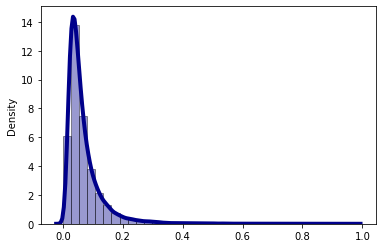

In [ ]:
sns.distplot(y_pred,hist=True,kde=True,bins=int(180/5),color="darkblue",hist_kws={"edgecolor":'black'},kde_kws={"linewidth":4})